## Análise Descritiva e Preditiva dos dados relativos ao Sistema de Operações do Crédito Rural e do Proagro (Sicor)

###  ADENILSON SILVA

## Criação de Modelos de _Machine Learning_

###  1 - Importando bibliotecas e criando funções

In [1]:
# Manipulação de dados
import pandas as pd  # Leitura e manipulação de dados em formato tabular (DataFrame)
import numpy as np  # Operações numéricas e vetoriais

# Visualização de dados
import matplotlib.pyplot as plt  # Criação de gráficos básicos
import seaborn as sns  # Visualizações estatísticas com interface mais amigável

# Ignorar avisos
import warnings  # Gerenciamento de avisos
warnings.filterwarnings("ignore")

# Pré-processamento
from sklearn.preprocessing import OrdinalEncoder  # Codificação de variáveis categóricas ordenadas

# Divisão e avaliação de modelos
from sklearn.model_selection import train_test_split, GridSearchCV  # Divisão dos dados e busca de hiperparâmetros
from sklearn import metrics  # Métricas diversas de avaliação

# Métricas específicas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,  # Métricas de classificação
    confusion_matrix, ConfusionMatrixDisplay,  # Matriz de confusão e visualização
)

# Modelos de classificação
from sklearn.ensemble import RandomForestClassifier  # Classificador Random Forest
from xgboost import XGBClassifier  # Classificador do XGBoost (gradient boosting)
from sklearn.naive_bayes import CategoricalNB  # Naive Bayes para variáveis categóricas
from sklearn.tree import DecisionTreeClassifier, plot_tree  # Árvore de decisão e visualização

# Salvamento e carregamento de modelos
import pickle  # Serialização de objetos Python (ex: salvar modelos treinados)

n_jobs=5
cv=5

In [2]:
def make_results_model(model_name, model_object):
    """
    Gera uma tabela com as principais métricas de avaliação (F1, recall, precisão e acurácia)
    do melhor modelo encontrado pelo GridSearchCV com base na média do F1-score.

    Parâmetros:
    -----------
    model_name : str
        Nome do modelo que será exibido na tabela (definido pelo usuário).

    model_object : sklearn.model_selection.GridSearchCV
        Objeto de modelo treinado (ajustado) do tipo GridSearchCV.

    Retorna:
    --------
    pandas.DataFrame
        Um DataFrame com uma linha contendo as seguintes métricas (em %):
        - f1: F1-score médio
        - Recall: Recall médio
        - Precision: Precisão média
        - Accuracy: Acurácia média
        - Best Score: Melhor F1-score médio obtido durante a validação cruzada
    """

    cv_results = pd.DataFrame(model_object.cv_results_)

    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    best_score = clf_model_2.best_score_.round(2)

    table = pd.DataFrame({'Model': [model_name + ' - Model (%)'],
                          'f1': [f1*100],
                          'Recall': [recall*100],
                          'Precision': [precision*100],
                          'Accuracy': [accuracy*100],
                          'Best Score': [best_score*100],
                         }
                        )
    return table


def make_results_test(model_name, y_test, y_pred, pos_label=1):
    """
    Calcula as métricas de avaliação de um modelo de classificação e retorna uma tabela com os resultados.

    Parâmetros:
    -----------
    model_name : str
        Nome do modelo que será exibido na tabela.
    
    y_test : array-like
        Valores reais (observados) das classes.
    
    y_pred : array-like
        Valores previstos pelo modelo.
    
    pos_label : int ou str, padrão=1
        Rótulo da classe considerada positiva nas métricas de precisão, recall e F1-score.

    Retorna:
    --------
    pandas.DataFrame
        Um dataframe com uma linha contendo as métricas:
        - f1: F1-score (%)
        - Recall: Recall (%)
        - Precision: Precisão (%)
        - Accuracy: Acurácia (%)
        - Best Score: Placeholder (usado para preenchimento, valor fixo '-')
    """
    accuracy =  accuracy_score(y_test, y_pred).round(2)
    precision = precision_score(y_test, y_pred, pos_label=pos_label).round(2)
    recall = recall_score(y_test, y_pred, pos_label=pos_label).round(2)
    f1 = f1_score(y_test, y_pred, pos_label=pos_label).round(2)

    table = pd.DataFrame({'Model': [model_name + ' - Test (%)'],
                          'f1': [f1*100],
                          'Recall': [recall*100],
                          'Precision': [precision*100],
                          'Accuracy': [accuracy*100],
                          'Best Score': '-',
                         }
                        )
    return table


def plot_confusion_matrix(y_true, y_pred, class_labels):
    """
    Plota a matriz de confusão usando os rótulos verdadeiros e previstos.

    Parâmetros:
    - y_true: array-like, rótulos reais.
    - y_pred: array-like, rótulos previstos pelo modelo.
    - class_labels: list ou array, nomes das classes (ex: clf.classes_).
    """
    cm = metrics.confusion_matrix(y_true, y_pred)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot()
    plt.show()
    

def plot_top_feature_importances(model, X_train, top_n=10, figsize=(12, 8)):
    """
    Plota as 'top_n' features mais importantes de um modelo baseado em árvore, 
    em formato de gráfico de barras horizontal (features no eixo Y).

    Parâmetros:
    - model: Objeto treinado com atributo `best_estimator_` (ex: GridSearchCV).
    - X_train: DataFrame com os dados de treino, usado para obter os nomes das features.
    - top_n: Número de features mais importantes a serem exibidas (default: 10).
    - figsize: Tamanho da figura do gráfico (default: (12, 8)).

    Retorna:
    - DataFrame com os nomes das top features e suas importâncias em porcentagem.
    """
    importances = model.best_estimator_.feature_importances_
    forest_importances = pd.Series(importances, index=X_train.columns).sort_values(ascending=False).head(top_n)

    fig, ax = plt.subplots(figsize=figsize)
    forest_importances.plot.bar(ax=ax)
    plt.title(f"Top {top_n} Importâncias das Features")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    model = model.best_estimator_.__class__.__name__
    top_features_df = ((forest_importances*100).round(2)).reset_index()
    top_features_df.columns = [model, 'importance %']
    return top_features_df

### 2 - Leitura dos dados

In [3]:
df = pd.read_parquet('dados/dados_tratados_ML/dados_tratados_ML.parquet')
df.head(5)

,finalidade,atividade,modalidade,produto,categoria_empresa,priorizacao
0,custeio,pecuario(a),pesca,armacao para barco de pesca,Em crescimento,Normal
30,custeio,agricola,lavoura,salsa,Em crescimento,Normal
72,custeio,agricola,lavoura,linho,Em crescimento,Normal
92,custeio,agricola,lavoura,lichia (lechia),Em crescimento,Normal
111,custeio,agricola,lavoura,palmeira,Em crescimento,Normal


In [4]:
df.describe()

,finalidade,atividade,modalidade,produto,categoria_empresa,priorizacao
count,1581,1581,1581,1581,1581,1581
unique,4,2,51,374,4,2
top,custeio,agricola,lavoura,cafe,Em crescimento,Normal
freq,701,1170,439,33,684,1265


### 3 - Modelo 1: CategoricalNB

In [5]:
df_model_1 = df.copy()

column_target = 'priorizacao'
y_model_1 = df_model_1[column_target]
X_model_1 = df_model_1.drop(column_target, axis=1)

encoder_model_1 = OrdinalEncoder()
X_encoder_model_1 = encoder_model_1.fit_transform(X_model_1)

X_train_model_1, X_test_model_1, y_train_model_1, y_test_model_1 = train_test_split(X_encoder_model_1, 
                                                                                    y_model_1, 
                                                                                    test_size=.2, 
                                                                                    stratify= y_model_1,
                                                                                    random_state=42)

In [6]:
%%time

model_1 = CategoricalNB()
model_1.fit(X_train_model_1, y_train_model_1) 

path = 'modelos/modelo_1_CategoricalNB/'
with open(path+'CategoricalNB_model.pickle', 'wb') as to_write: 
    pickle.dump(model_1, to_write)
with open(path + 'CategoricalNB_model.pickle', 'rb') as to_read:
    model_1 = pickle.load(to_read)

Wall time: 34.3 ms


In [7]:
y_pred_model_1 = model_1.predict(X_test_model_1)

#print(classification_report(y_test_model_1, y_pred_model_1)) # relatório alternativo 
model_name = 'CategoricalNB'
results_model_1 = make_results_test(model_name, y_test_model_1, y_pred_model_1, pos_label='Normal')
results_model_1

,Model,f1,Recall,Precision,Accuracy,Best Score
0,CategoricalNB - Test (%),91.0,90.0,92.0,85.0,-


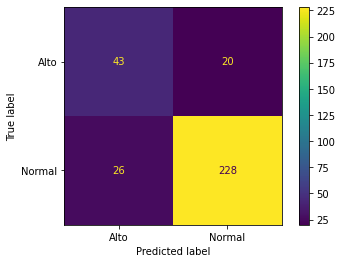

In [8]:
plot_confusion_matrix(y_test_model_1, y_pred_model_1, model_1.classes_)

### 4 - Modelo 2: DecisionTreeClassifier

In [9]:
df_model_2 = df.copy()
df_model_2 = pd.get_dummies(df_model_2, drop_first=True)

column_target = 'priorizacao_Normal'
y_model_2 = df_model_2[column_target]
X_model_2 = df_model_2.drop(column_target, axis=1)

X_train_model_2, X_test_model_2, y_train_model_2, y_test_model_2 = train_test_split(X_model_2, 
                                                                                    y_model_2, 
                                                                                    test_size=.2, 
                                                                                    stratify= y_model_2,
                                                                                    random_state=42)

In [10]:
%%time

model_2 = DecisionTreeClassifier(random_state = 42)

cv_model_2 = {'max_depth': [2,3,4,5, 10, None],
             'min_samples_leaf': [1, 3, 5, 8, 10]}

scoring_model_2 = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}


clf_model_2 = GridSearchCV(model_2, 
                   cv_model_2, 
                   scoring = scoring_model_2, 
                   cv=cv, 
                   refit="f1",
                   n_jobs=n_jobs)

clf_model_2.fit(X_train_model_2, y_train_model_2)

Wall time: 4.71 s


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=5,
             param_grid={'max_depth': [2, 3, 4, 5, 10, None],
                         'min_samples_leaf': [1, 3, 5, 8, 10]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [11]:
path = 'modelos/modelo_2_DecisionTreeClassifier/'
with open(path+'DecisionTreeClassifier.pickle', 'wb') as to_write:
    pickle.dump(clf_model_2, to_write)
with open(path + 'DecisionTreeClassifier.pickle', 'rb') as to_read:
    clf_model_2 = pickle.load(to_read)

In [12]:
clf_model_2.best_params_

{'max_depth': None, 'min_samples_leaf': 1}

In [13]:
y_pred_model_2 = clf_model_2.predict(X_test_model_2)

model_name = 'DecisionTreeClassifier'
results_model_2 = pd.concat([make_results_test(model_name, y_test_model_2, y_pred_model_2), 
                             make_results_model(model_name, clf_model_2)], ignore_index=True).round(2)
results_model_2

,Model,f1,Recall,Precision,Accuracy,Best Score
0,DecisionTreeClassifier - Test (%),99.00,98.00,100.00,98.00,-
1,DecisionTreeClassifier - Model (%),97.17,96.74,97.64,95.49,97.0


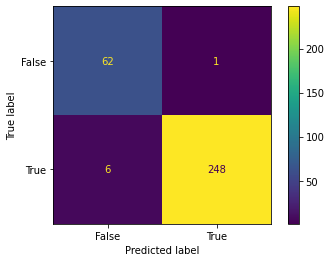

In [14]:
plot_confusion_matrix(y_test_model_2, y_pred_model_2, clf_model_2.classes_)

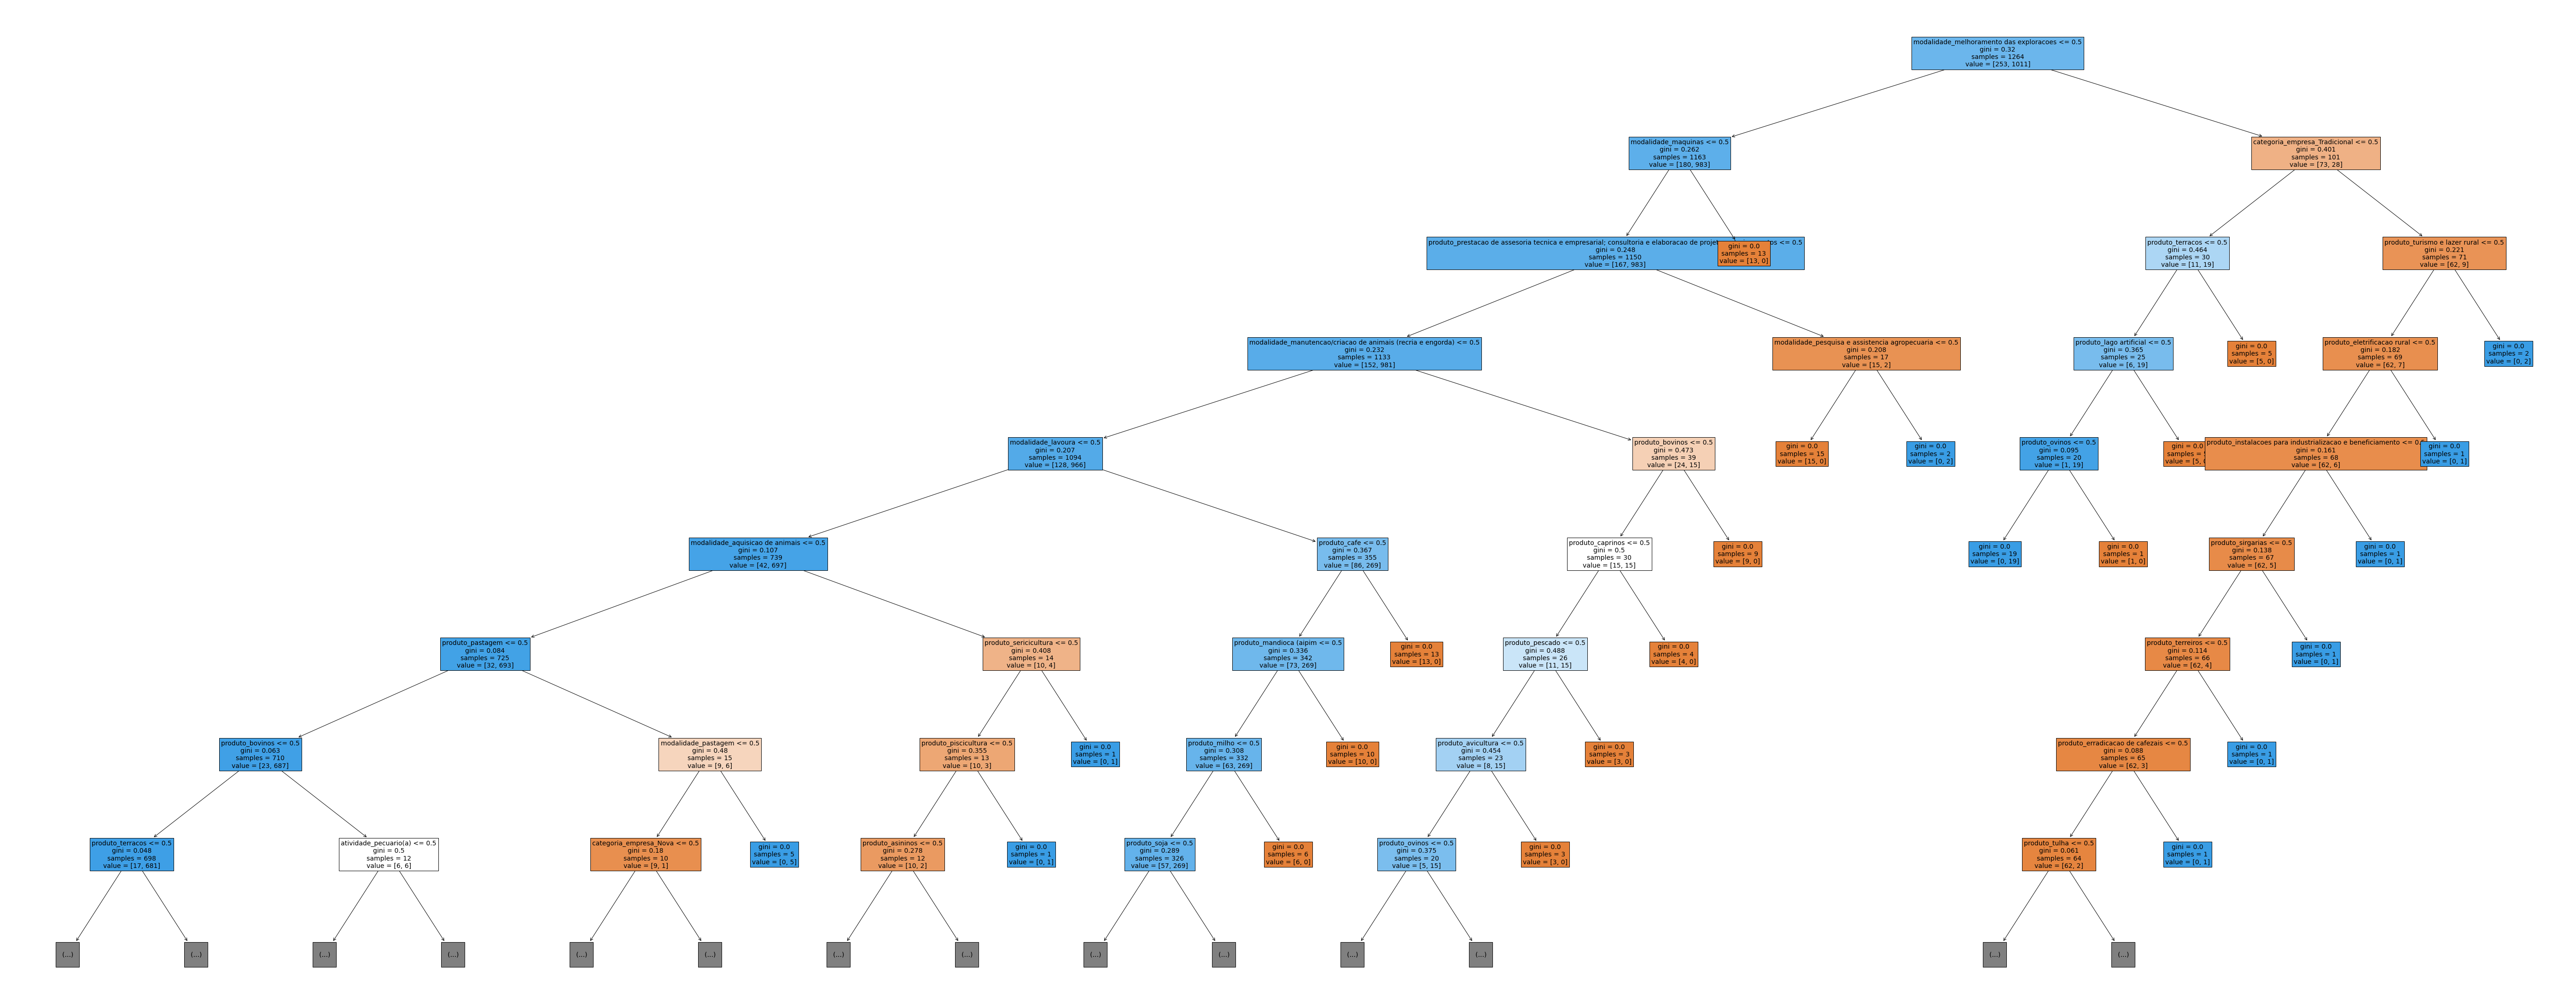

In [15]:
plt.figure(figsize=(100,40))
plot_tree(clf_model_2.best_estimator_, max_depth=8, fontsize=14, feature_names=X_train_model_2.columns.tolist(), filled=True);
plt.show()

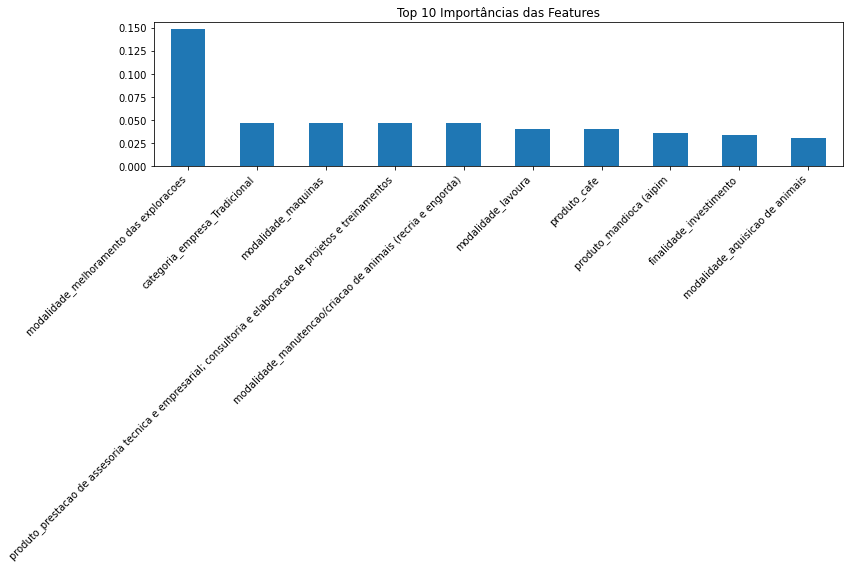

In [16]:
top_10_features_model_2 = plot_top_feature_importances(clf_model_2, X_train_model_2)

### 5 - Modelo 3: RandomForestClassifier

In [17]:
df_model_3 = df.copy()
df_model_3 = pd.get_dummies(df_model_3, drop_first=True)

column_target = 'priorizacao_Normal'
y_model_3 = df_model_3[column_target]
X_model_3 = df_model_3.drop(column_target, axis=1)

X_train_model_3, X_test_model_3, y_train_model_3, y_test_model_3 = train_test_split(X_model_3, 
                                                                                    y_model_3, 
                                                                                    test_size=.2, 
                                                                                    stratify= y_model_3,
                                                                                    random_state=42)

In [18]:
%%time

model_3 = RandomForestClassifier(random_state=42, n_jobs=n_jobs)

cv_model_3 = {'max_depth': [2,3,4,5, 10, None], 
             'min_samples_leaf': [1, 5, 10],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 150]
             } 

scoring_model_3 = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

clf_model_3 = GridSearchCV(model_3, cv_model_3, scoring=scoring_model_3, cv=cv, refit='f1', n_jobs=n_jobs)

clf_model_3.fit(X_train_model_3, y_train_model_3)

Wall time: 4min 16s


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=5, random_state=42),
             n_jobs=5,
             param_grid={'max_depth': [2, 3, 4, 5, 10, None],
                         'max_features': [2, 3, 4],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [75, 100, 150]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [19]:
path = 'modelos/modelo_3_RandomForestClassifier/'
with open(path+'RandomForestClassifier.pickle', 'wb') as to_write:
    pickle.dump(clf_model_3, to_write)
with open(path + 'RandomForestClassifier.pickle', 'rb') as to_read:
    clf_model_3 = pickle.load(to_read)

In [20]:
clf_model_3.best_params_

{'max_depth': None,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 75}

In [21]:
y_pred_model_3 = clf_model_3.predict(X_test_model_3)

model_name = 'RandomForestClassifier'
results_model_3 = pd.concat([make_results_test(model_name, y_test_model_3, y_pred_model_3), 
                             make_results_model(model_name, clf_model_3)], ignore_index=True).round(2)
results_model_3

,Model,f1,Recall,Precision,Accuracy,Best Score
0,RandomForestClassifier - Test (%),98.00,97.00,99.00,97.00,-
1,RandomForestClassifier - Model (%),98.03,98.52,97.58,96.84,97.0


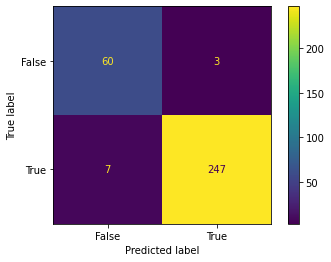

In [22]:
plot_confusion_matrix(y_test_model_3, y_pred_model_3, clf_model_3.classes_)

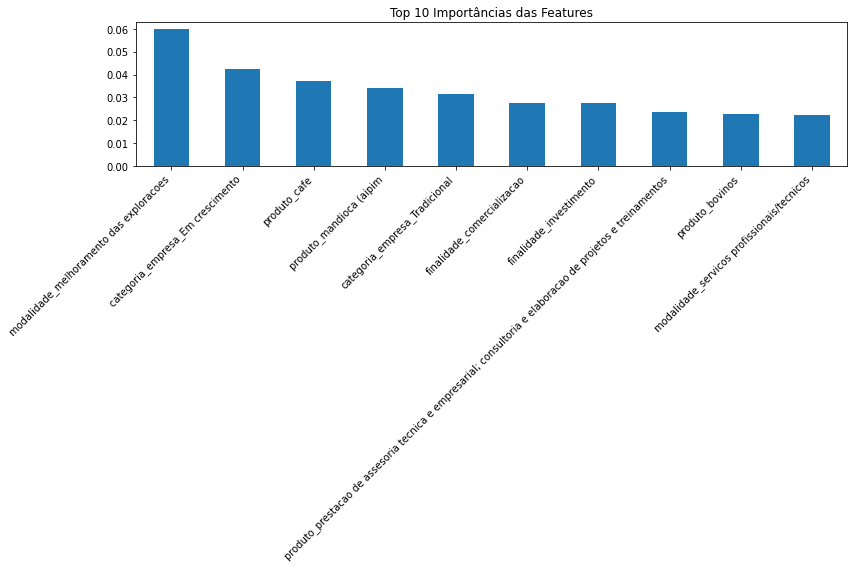

In [23]:
top_10_features_model_3 = plot_top_feature_importances(clf_model_3, X_train_model_3)

### 6 - Model 4: XGBoost tuning

In [24]:
df_model_4 = df.copy()
df_model_4 = pd.get_dummies(df_model_4, drop_first=True)

column_target = 'priorizacao_Normal'
y_model_4 = df_model_4[column_target]
X_model_4 = df_model_4.drop(column_target, axis=1)

X_train_model_4, X_test_model_4, y_train_model_4, y_test_model_4 = train_test_split(X_model_4, 
                                                                                    y_model_4, 
                                                                                    test_size=.2, 
                                                                                    stratify= y_model_4,
                                                                                    random_state=42)

In [25]:
%%time

model_4 = XGBClassifier(objective='binary:logistic', random_state=42, n_jobs=n_jobs) 

cv_model_4 = {'max_depth': [2,3,4,5, 10, None],
             'min_child_weight': [1,2, 4,5],
             'learning_rate': [0.1, 0.2, 0.3],
             'n_estimators': [75, 100, 150]
             }   

scoring_model_4 = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

clf_model_4 = GridSearchCV(model_4, cv_model_4, scoring=scoring_model_4, cv=cv, refit='f1', n_jobs=n_jobs)

clf_model_4.fit(X_train_model_4, y_train_model_4)

Wall time: 3min 39s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=5, num_parallel_tree=None,
                                     random_state=42, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [2, 3, 4, 5, 10, None],
                         'min_child_weight': [1, 2, 4, 5],
                         'n_estimators': [75, 100, 150]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall'})

In [26]:
path = 'modelos/modelo_4_XGBClassifier/'
with open(path+'XGBClassifier.pickle', 'wb') as to_write:
    pickle.dump(clf_model_4, to_write)
with open(path + 'XGBClassifier.pickle', 'rb') as to_read:
    clf_model_4 = pickle.load(to_read)

In [27]:
clf_model_4.best_params_

{'learning_rate': 0.2,
 'max_depth': None,
 'min_child_weight': 1,
 'n_estimators': 150}

In [28]:
y_pred_model_4 = clf_model_4.predict(X_test_model_4)

model_name = 'XGBClassifier'
results_model_4 = pd.concat([make_results_test(model_name, y_test_model_4, y_pred_model_4), 
                             make_results_model(model_name, clf_model_4)], ignore_index=True).round(2)
results_model_4

,Model,f1,Recall,Precision,Accuracy,Best Score
0,XGBClassifier - Test (%),96.00,97.00,95.00,93.00,-
1,XGBClassifier - Model (%),95.59,98.32,93.04,92.72,97.0


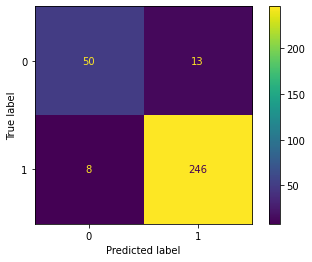

In [29]:
plot_confusion_matrix(y_test_model_4, y_pred_model_4, clf_model_4.classes_)

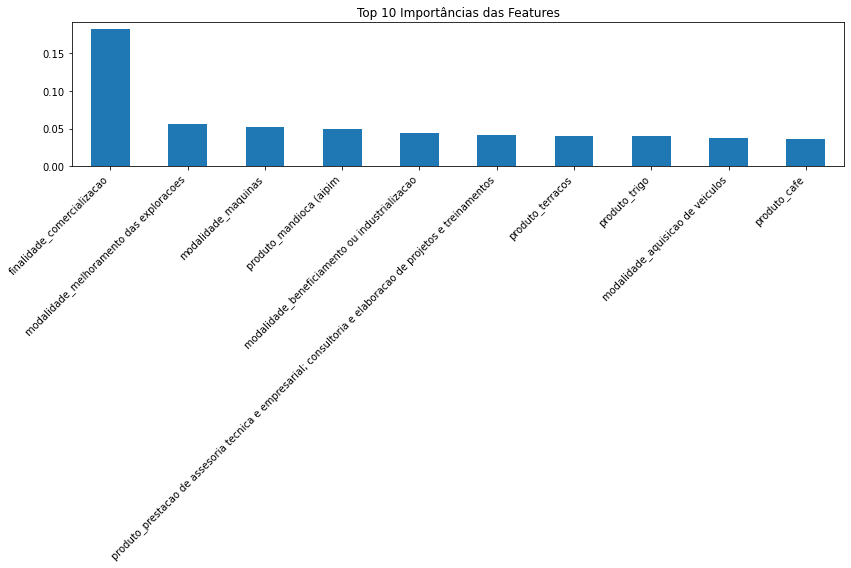

In [30]:
top_10_features_model_4 = plot_top_feature_importances(clf_model_4, X_train_model_4)

### 7 - Resultados 

In [31]:
all_results = pd.concat([results_model_1, results_model_2, results_model_3, results_model_4], axis=0)
all_results.sort_values(['f1', 'Precision', 'Recall', 'Accuracy', 'Best Score'], ascending=False, ignore_index=True)

,Model,f1,Recall,Precision,Accuracy,Best Score
0,DecisionTreeClassifier - Test (%),99.00,98.00,100.00,98.00,-
1,RandomForestClassifier - Model (%),98.03,98.52,97.58,96.84,97.0
2,RandomForestClassifier - Test (%),98.00,97.00,99.00,97.00,-
3,DecisionTreeClassifier - Model (%),97.17,96.74,97.64,95.49,97.0
4,XGBClassifier - Test (%),96.00,97.00,95.00,93.00,-
5,XGBClassifier - Model (%),95.59,98.32,93.04,92.72,97.0
6,CategoricalNB - Test (%),91.00,90.00,92.00,85.00,-


In [32]:
pd.concat([top_10_features_model_2, top_10_features_model_3, top_10_features_model_4], axis=1)

,DecisionTreeClassifier,importance %,RandomForestClassifier,importance %,XGBClassifier,importance %
0,modalidade_melhoramento das exploracoes,14.82,modalidade_melhoramento das exploracoes,5.98,finalidade_comercializacao,18.190001
1,categoria_empresa_Tradicional,4.68,categoria_empresa_Em crescimento,4.26,modalidade_melhoramento das exploracoes,5.570000
2,modalidade_maquinas,4.64,produto_cafe,3.74,modalidade_maquinas,5.270000
3,produto_prestacao de assesoria tecnica e empre...,4.63,produto_mandioca (aipim,3.40,produto_mandioca (aipim,4.890000
4,modalidade_manutencao/criacao de animais (recr...,4.62,categoria_empresa_Tradicional,3.16,modalidade_beneficiamento ou industrializacao,4.410000
5,modalidade_lavoura,4.07,finalidade_comercializacao,2.77,produto_prestacao de assesoria tecnica e empre...,4.160000
6,produto_cafe,3.98,finalidade_investimento,2.76,produto_terracos,4.030000
7,produto_mandioca (aipim,3.59,produto_prestacao de assesoria tecnica e empre...,2.35,produto_trigo,3.980000
8,finalidade_investimento,3.34,produto_bovinos,2.28,modalidade_aquisicao de veiculos,3.770000
9,modalidade_aquisicao de animais,3.05,modalidade_servicos profissionais/tecnicos,2.23,produto_cafe,3.550000


### Dados sobre versão

In [33]:
import sys
import pandas as pd
import numpy as np
import sklearn as skl
import matplotlib as mat
import xgboost as xgb
print("Python:", sys.version)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)
print("sklearn:", skl.__version__)
print("matplotlib:", mat.__version__)
print("xgboost:", xgb.__version__)

Python: 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
pandas: 2.2.3
numpy: 1.23.5
sklearn: 1.3.0
matplotlib: 3.9.4
xgboost: 2.1.4
